In [1]:
%pylab inline
import pandas as pd;
import numpy as np;
from matplotlib import style
import os;
import glob
import pickle
import json
import matplotlib.pyplot as plt

import scipy.io as sio
import scipy.fftpack
import scipy.signal
import scipy.io.wavfile
from scipy import stats
from scipy import signal

from open_ephys.analysis import Session

plt.rcParams['font.size'] = 20

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


File_name:  Neuropix-PXI-100.ProbeB-LFP/
Sampling points:  3122760
total channel number: 384


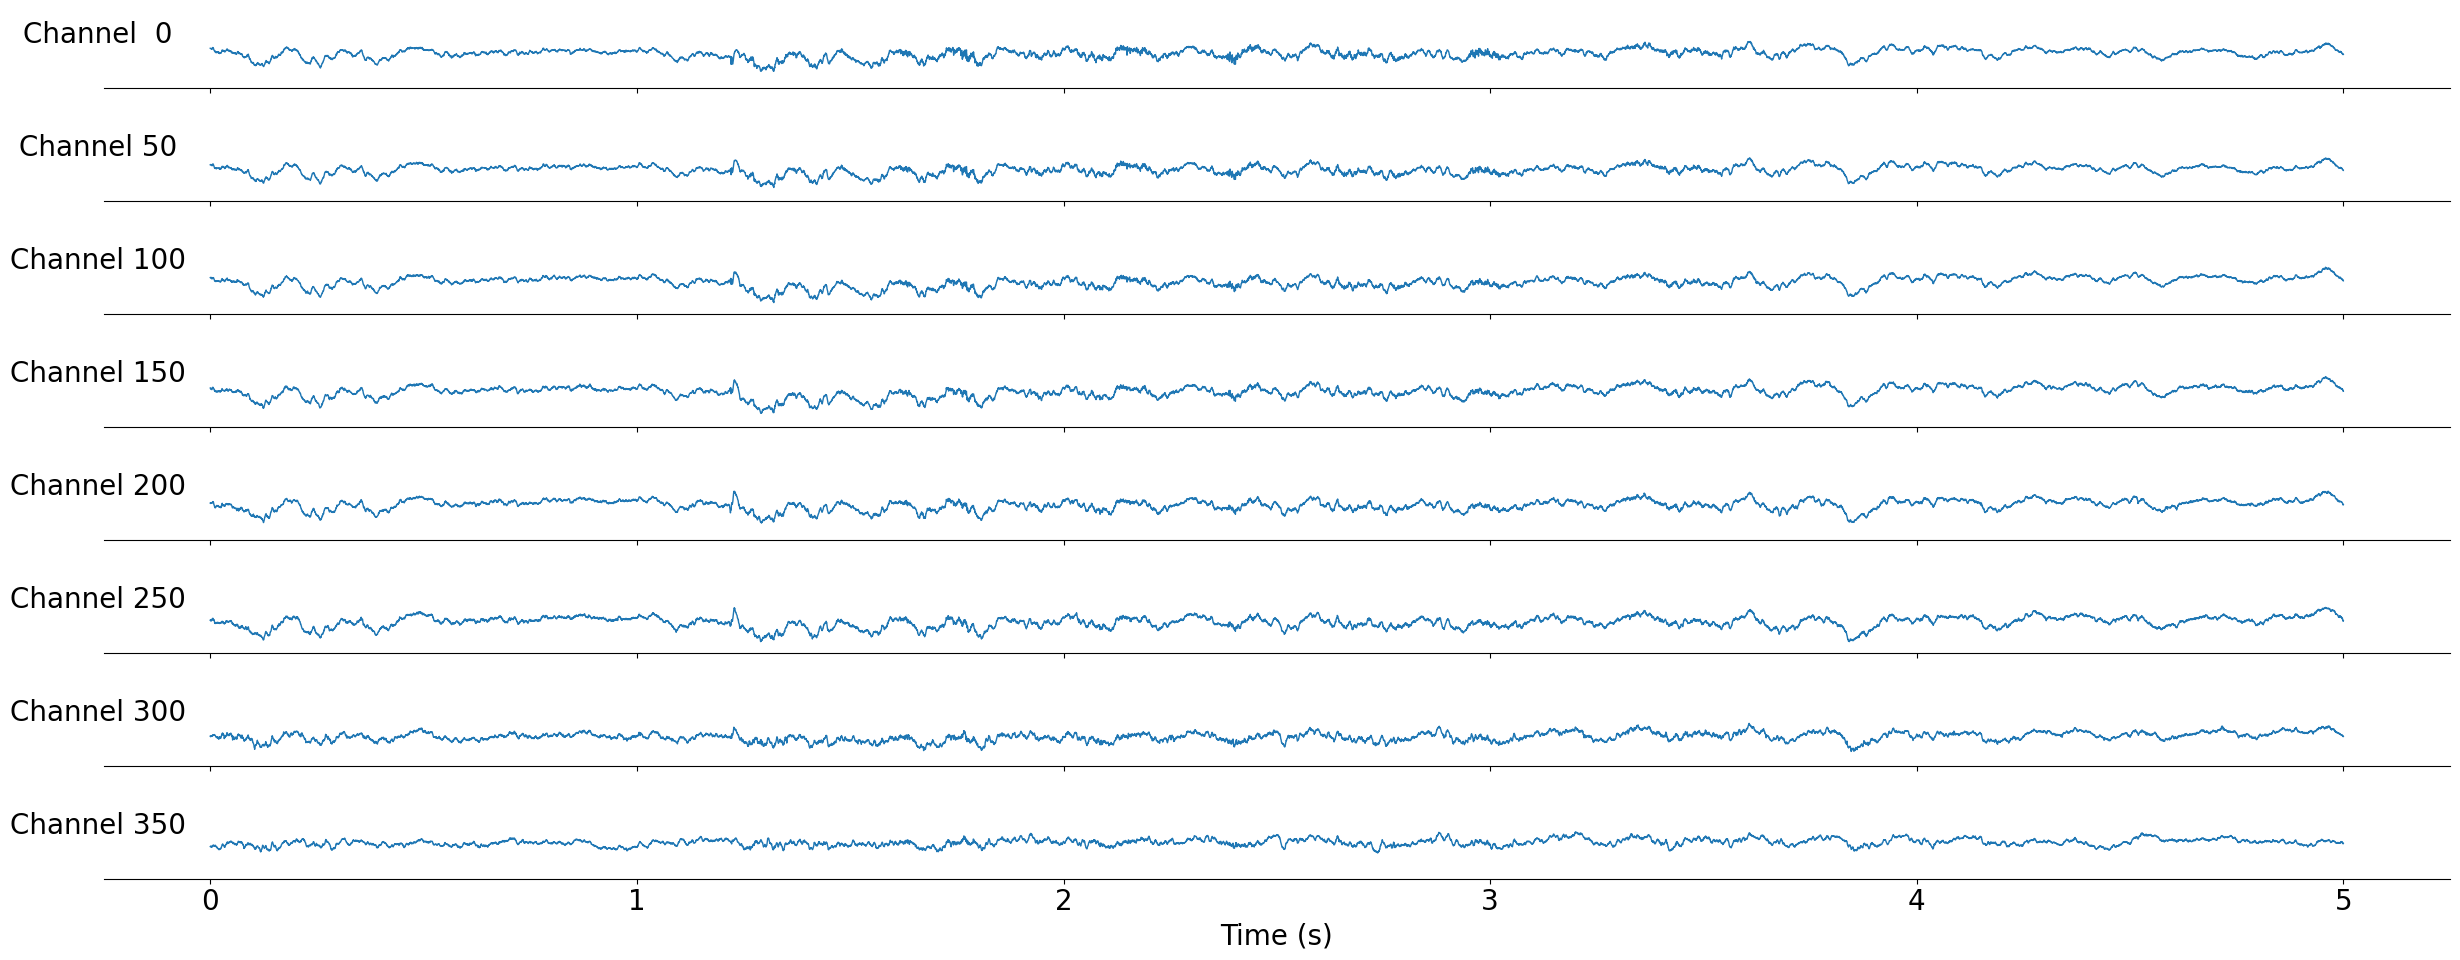

In [2]:
# Loading Data
#path = 'H:\\neuropixels\\'
path = 'D:\\_work_cestarellas\\Analysis\\Claudia_LFP\\20230929\\Data\\'

folder_oe = 'CE31_2023-09-29_12-43-48_DR'                                                           # folder open ephys data
directory = path+folder_oe

# To read neuropixel recording
session = Session(directory)
recording = session.recordnodes[0].recordings[0]
# Give the name of the recording streams (LFP, AP, TTL) and the sampling points of the recorded data
rec_info = [recording.continuous[i].name for i in range(len(recording.continuous))]
data_pos = [rec_info.index(i) for i in rec_info if 'LFP' in i]
# Duration of the recording in sampling_point
recdur = len(recording.continuous[data_pos[0]].sample_numbers)
rec_name = recording.continuous[data_pos[0]].name
print('File_name: ',rec_name)
print('Sampling points: ', recdur)

# In this recording we have three differnt probes
data_LFP = recording.continuous[data_pos[0]].get_samples(start_sample_index=0, end_sample_index=recdur)
# print information
print("total channel number:", data_LFP.shape[1])

# for selecting number of channels transpose the first matrix
data_T = data_LFP.T

# select the number of channels 
n_ch = 384
step = 50
chann_select = data_T[0:n_ch:step] # used to plot many channels independent
chann_plot = chann_select.T #used for a fast plot

# number of selected channels to plot
total_select = len(chann_select)
chann_select.shape

fig, ax = plt.subplots(nrows = total_select, ncols =1, figsize = (25,10), sharex = True)
sm_rate = 2500
xlim = sm_rate*0#52
ylim = sm_rate*5#57
time_vec = np.linspace(xlim/sm_rate,ylim/sm_rate,ylim)

for i, ch in enumerate(range(total_select)): # from channel 0 to channel 15
    ax[i].plot(time_vec,chann_select[ch][xlim:ylim], lw = 1) # 20_000 samples means one second of recording
    ax[i].set_ylim(-600,1200) # y-axis limts
    ax[i].set_ylabel(f'Channel {ch*step:2d}', rotation=0) # write a label
    ax[i].set_yticks([])
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['left'].set_visible(False)
ax[total_select-1].set_xlabel('Time (s)')
plt.tight_layout()

Text(0, 0.5, "Animal's choice")

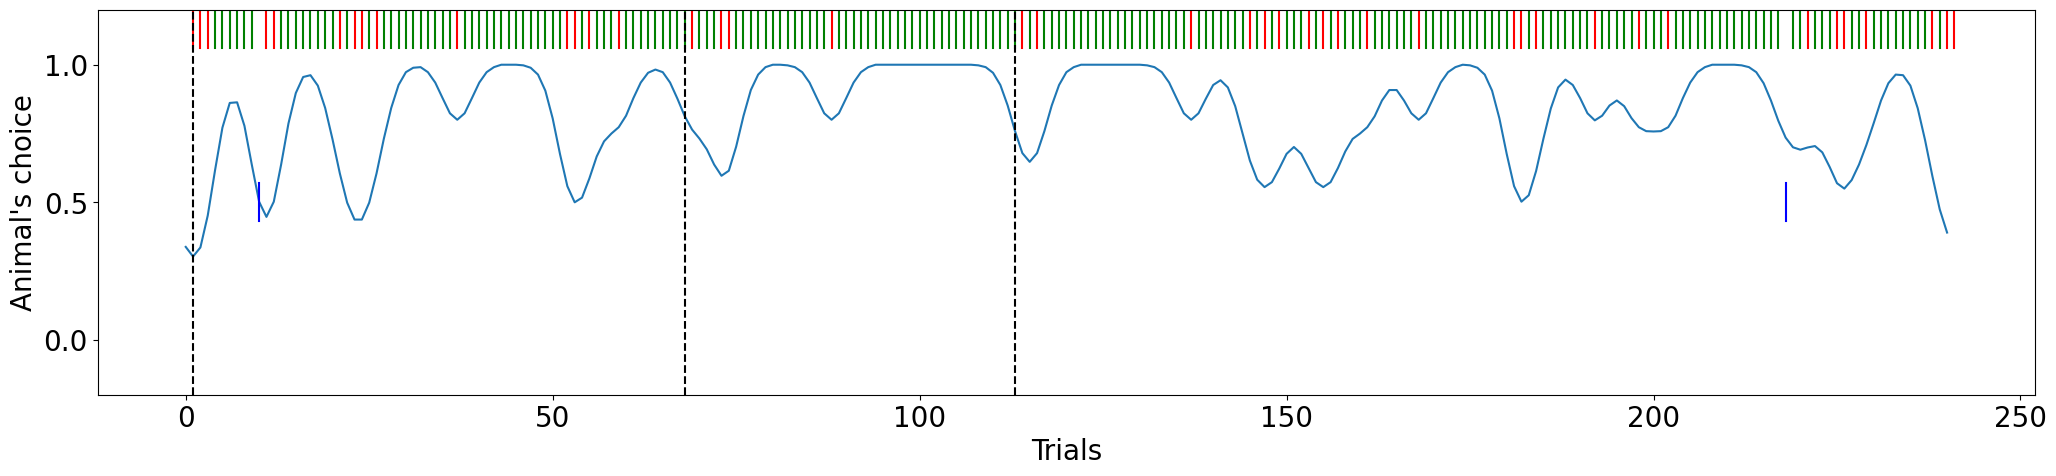

In [3]:
# Loading Behaviour
# behavioral information
session_pybpod = "20230929-124324" # name of the csv file
TTLsummaryname = path + session_pybpod + '_TTLbehav_LFP.pkl'
session_ttl = pd.read_pickle(TTLsummaryname)

# Classification of trials following the behabiour
CorrectTrials = session_ttl[(session_ttl["Correct"]==1) & (session_ttl["Response"]==1)].index
IncorrectTrials =  session_ttl[(session_ttl["Correct"]==0) & (session_ttl["Response"]==1)].index
NoRespondingTrials = session_ttl[session_ttl["Response"]==0].index

# Blocks
Block_Rule = np.unique(session_ttl["Rule"])
RuleTrials = [session_ttl[session_ttl["Rule"]==Block_Rule[i]].index[0] for i in Block_Rule]
# Smoothing the data for plotting
CorrectDecision=session_ttl["Correct"]+(session_ttl["Correct"]-1)
SigmaDecision=1
Binx =0.5
KernelWindow = np.arange(-3*SigmaDecision, 3*SigmaDecision, Binx)
KernelDecision = np.exp(-(KernelWindow/SigmaDecision)**2/2)
DecisionConvolution=np.convolve(CorrectDecision,KernelDecision,mode='same')
DecisionNormalized=(DecisionConvolution/np.nanmax(np.abs(DecisionConvolution))+1)/2
if NoRespondingTrials[0]<20:
    first_trial = NoRespondingTrials[0]+1
    last_trial = NoRespondingTrials[1]-1
else:
    first_trial = 0
    last_trial = NoRespondingTrials[0]-1
    
first_trial = 0
last_trial = NoRespondingTrials[0]-1

# FIGURE: Plot behaviour performance
plt.figure(figsize=(25,5))
plt.plot(DecisionNormalized)
for i in CorrectTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='g') 
for i in IncorrectTrials:
    plt.axvline(i,ymin=0.9,ymax=1.0,color='red')
for i in NoRespondingTrials:
    plt.axvline(i,ymin=0.45,ymax=0.55,color='blue')
for i in RuleTrials:
    plt.axvline(i,linestyle='dashed',color='k',)     
plt.ylim([-0.2,1.2])
plt.yticks(ticks=[1.0,0.5,0.0])

plt.xlabel('Trials')
plt.ylabel("Animal's choice")


# Analyzing LFP full session

In [4]:
# Intial and Final temporal points
Ti = session_ttl["TTL_start"][1]
Tf = session_ttl["TTL_end"][len(session_ttl)]
srate = 2500
# time vector
LFP =  chann_select[0][Ti:Tf]
LFP = LFP - LFP.mean()
sampling_rate = 2500
N = len(LFP)

Text(0.5, 0, 'Frequency (Hz)')

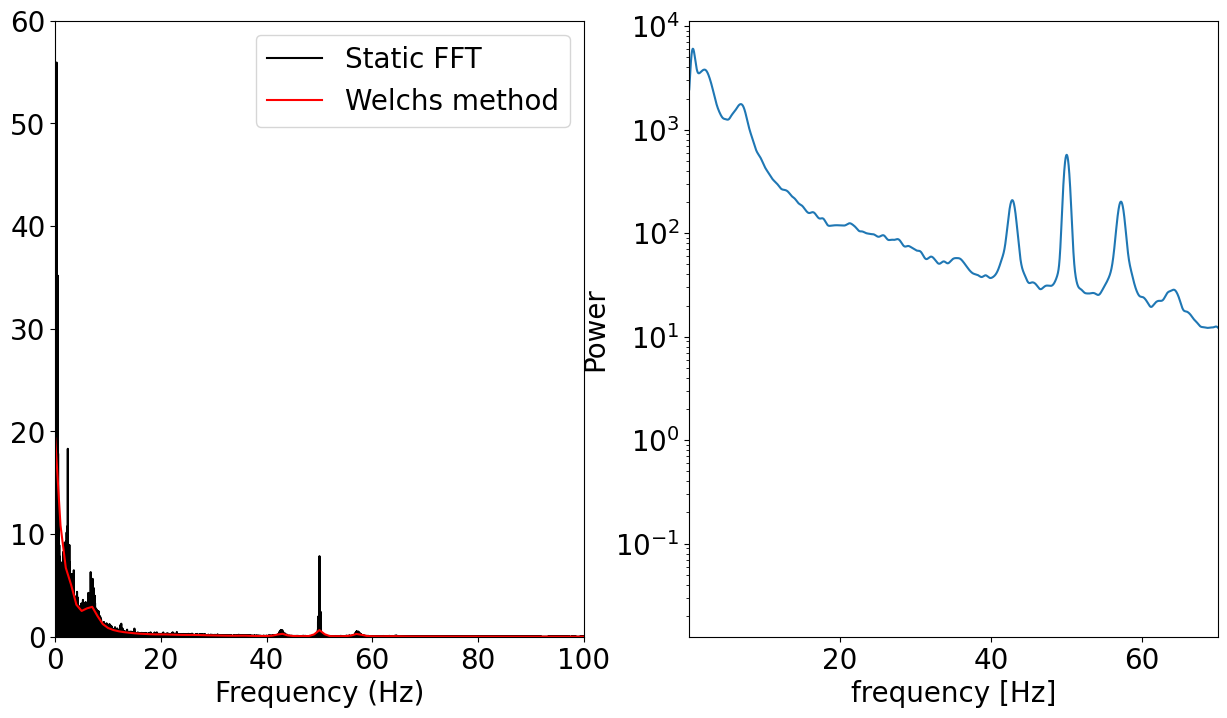

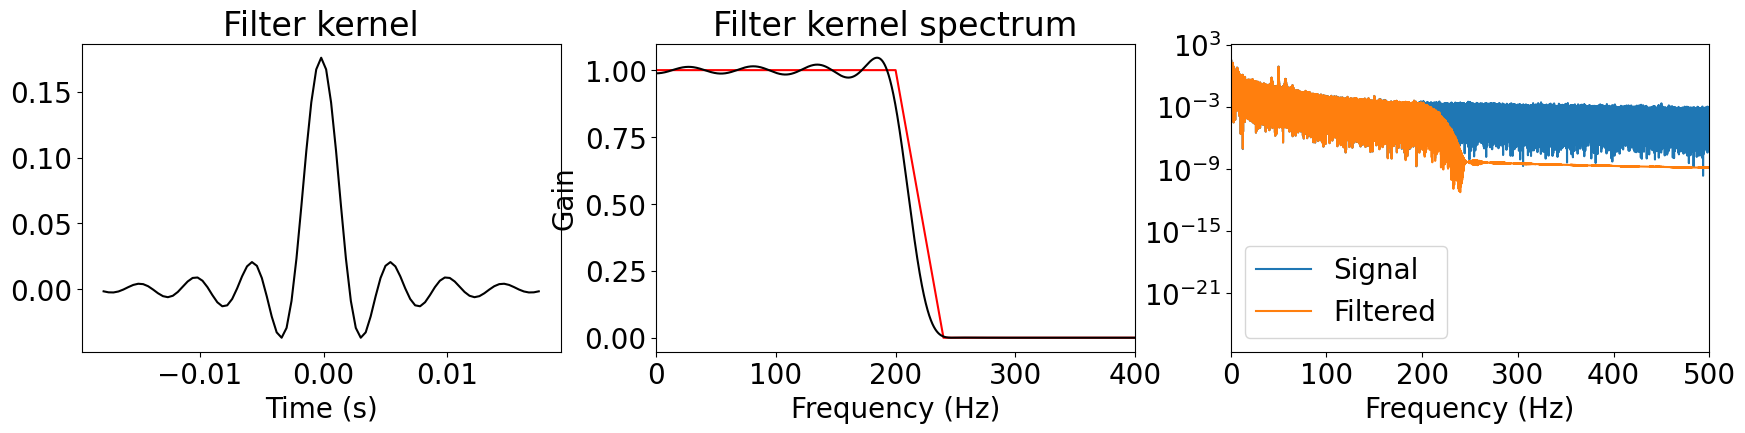

In [5]:
# 1. Power spectrum
## one big FFT (not Welch's method)
# "static" FFT over entire period, for comparison with Welch
lfppow = np.abs(scipy.fftpack.fft(LFP)/N )**2 ## power spectrum
hz = np.linspace(0,srate/2,int(np.floor(N/2)+1))

## 1 "manual" Welch's method
winlength = int( 1*srate )# window length in seconds*srate
nOverlap = np.round(srate/2)# number of points of overlap

# window onset times
winonsets = np.arange(0,int(N-winlength),int(winlength-nOverlap))
# note: different-length signal needs a different-length Hz vector
hzW = np.linspace(0,srate/2,int(floor(winlength/2)+1))
# Hann window
hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,int(winlength)))/2
# initialize the power matrix (windows x frequencies)
lfppowW = np.zeros(len(hzW))

# loop over frequencies
for wi in range(0,len(winonsets)):
    datachunk = LFP[ winonsets[wi]:winonsets[wi]+winlength ]# get a chunk of data from this time window
    datachunk = datachunk * hannw# apply Hann taper to data
    tmppow = np.abs(scipy.fftpack.fft(datachunk)/winlength)**2 # compute its power
    lfppowW = lfppowW  + tmppow[0:len(hzW)]# enter into matrix

lfppowW = lfppowW / len(winonsets)# divide by N

## 2 Python's welch
# create Hann window
winsize = int( 2*srate ) # 2-second window size
hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

# number of FFT points (frequency resolution)
nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
# here by diving by 4 we have 25% overlap
f, welchpow = scipy.signal.welch(LFP,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)

# 3 Plotting
fig,ax = plt.subplots(1, 2, figsize = (15,8), sharex = False)
ax[0].plot(hz,lfppow[0:len(hz)],'k',label='Static FFT')
ax[0].plot(hzW,lfppowW/100,'r',label='Welch''s method')
#ax[0].set_yscale('log')
ax[0].set_xlim([0,100])
ax[0].set_ylim([0,60])
ax[0].set_xlabel('Frequency (Hz)')
ax[0].legend()

ax[1].semilogy(f,welchpow)
ax[1].set_xlim([0.1,70])
ax[1].set_xlabel('frequency [Hz]')
ax[1].set_ylabel('Power')

### 3 Low pass filters
#3.1 create the loww pass filter
fcutoff = 200  # frequency that cut off
transw  = .2 # transition widht 20%
order   = np.round( 7*srate/fcutoff )+1 # the order would be 7 times the cutoff frequency

# shape in the y axis or the shape of the kernel.
shape   = [ 1,1,0,0 ]  
#Normally we use 6 points but here only 4 because a DC has the already value 1 (first value)
frex    = [ 0, fcutoff, fcutoff+fcutoff*transw, srate/2 ]
# filter kernel
filtkern = signal.firls(order,frex,shape,fs=srate) # here we use the firls function to generate the kernel
# its power spectrum
filtkernX = np.abs(scipy.fftpack.fft(filtkern,N))**2 # so we can visualize the filter

#3.2 now apply the filter to the data
yFilt = signal.filtfilt(filtkern,1,LFP) # filtered data in the time domain

### power spectra of original and filtered signal
yOrigX = np.abs(scipy.fftpack.fft(LFP)/N)**2
yFiltX = np.abs(scipy.fftpack.fft(yFilt)/N)**2 #filtered data in the frequency domain

### Ploting the information
fig,ax = plt.subplots(1, 3, figsize = (21,4))
# first plot is the filter kernel in the time domain
ax[0].plot(np.arange(-order/2,order/2)/srate,filtkern,'k')
ax[0].set_xlabel('Time (s)')
ax[0].set_title('Filter kernel')

# here in color is the ideal filter response, black empirical response
ax[1].plot(np.array(frex),shape,'r')
ax[1].plot(hz,filtkernX[:len(hz)],'k')
ax[1].set_xlim([0,400])
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Gain')
ax[1].set_title('Filter kernel spectrum')

ax[2].plot(hz,yOrigX[:len(hz)],label='Signal')
ax[2].plot(hz,yFiltX[:len(hz)],label='Filtered')
ax[2].set_xlim([0,srate/5])
ax[2].set_yscale('log')
ax[2].legend()
ax[2].set_xlabel('Frequency (Hz)')


In [6]:
# Reward and No Reward trials
LFP=yFilt
rew_sess = session_ttl[(session_ttl["Response"]==1) & (session_ttl["Correct"]==1)]
unrew_sess = session_ttl[(session_ttl["Response"]==1) & (session_ttl["Incorrect"]==1)]

Text(0, 0.5, 'Power')

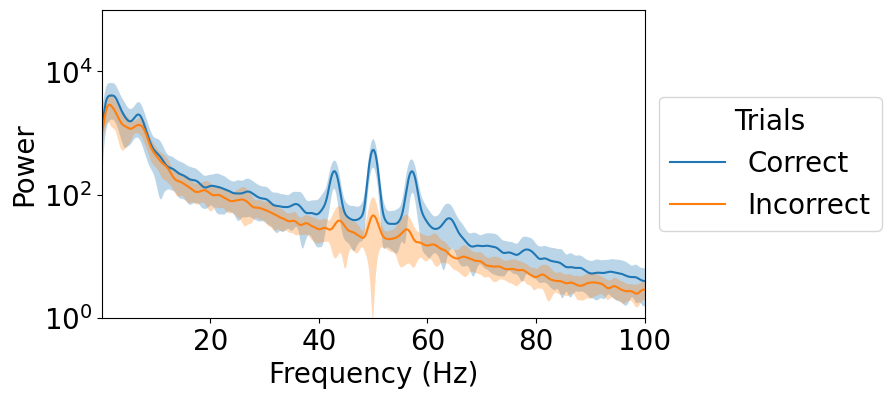

In [7]:
# Reward Power Spectrum
freq_rew = []
lfp_rew = []
for i in range(len(rew_sess)):
    # Intial and Final temporal points
    Ti = rew_sess["TTL_start"].iloc[i]
    Tf = rew_sess["TTL_end"].iloc[i]
    srate = 2500
    # time vector
    LFP_rew =  chann_select[0][Ti:Tf]
    LFP_rew = LFP_rew - LFP_rew.mean()
    sampling_rate = 2500
    N = len(LFP_rew)

    # create Hann window
    winsize = int(srate) # 2-second window size
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

    # number of FFT points (frequency resolution)
    nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
    # here by diving by 4 we have 25% overlap
    f, welchpow = scipy.signal.welch(LFP_rew,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)
    freq_rew.append(f)
    lfp_rew.append(welchpow)

F_rew = np.array(freq_rew).mean(0)
PS_rew = np.array(lfp_rew).mean(0)
PS_rew_std = np.array(lfp_rew).std(0)

# Unreward Power Spectrum
freq_unrew = []
lfp_unrew = []
for i in range(len(unrew_sess)):
    # Intial and Final temporal points
    Ti = unrew_sess["TTL_start"].iloc[i]
    Tf = unrew_sess["TTL_end"].iloc[i]
    srate = 2500
    # time vector
    LFP_unrew =  chann_select[0][Ti:Tf]
    LFP_unrew = LFP_unrew - LFP_unrew.mean()
    sampling_rate = 2500
    N = len(LFP_unrew)

    # create Hann window
    winsize = int(srate) # 2-second window size
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

    # number of FFT points (frequency resolution)
    nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
    # here by diving by 4 we have 25% overlap
    f, welchpow = scipy.signal.welch(LFP_unrew,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)
    freq_unrew.append(f)
    lfp_unrew.append(welchpow)

F_unrew = np.array(freq_unrew).mean(0)
PS_unrew = np.array(lfp_unrew).mean(0)
PS_unrew_std = np.array(lfp_unrew).std(0)

plt.figure(figsize=(7,4))
plt.semilogy(F_rew,PS_rew, label = 'Correct')
plt.fill_between(F_rew, PS_rew - PS_rew_std, PS_rew + PS_rew_std, alpha=0.3)
plt.semilogy(F_unrew,PS_unrew, label = 'Incorrect')
plt.fill_between(F_unrew, PS_unrew - PS_unrew_std, PS_unrew + PS_unrew_std, alpha=0.3)
plt.xlim([0.1,100])
plt.ylim([1,100000])
plt.legend(title="Trials",loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")

In [8]:
# Rules and Correct
# Rule1:
rule1_corr = session_ttl[(session_ttl["Response"]==1) & (session_ttl["Correct"]==1) & (session_ttl["Rule"]==0)]
rule1_incorr = session_ttl[(session_ttl["Response"]==1) & (session_ttl["Incorrect"]==1) & (session_ttl["Rule"]==0)]
# Rule 2:
rule2_corr = session_ttl[(session_ttl["Response"]==1) & (session_ttl["Correct"]==1) & (session_ttl["Rule"]==1)]
rule2_incorr = session_ttl[(session_ttl["Response"]==1) & (session_ttl["Incorrect"]==1) & (session_ttl["Rule"]==1)]
# Rule 3:
rule3_corr = session_ttl[(session_ttl["Response"]==1) & (session_ttl["Correct"]==1) & (session_ttl["Rule"]==2)]
rule3_incorr = session_ttl[(session_ttl["Response"]==1) & (session_ttl["Incorrect"]==1) & (session_ttl["Rule"]==2)]

In [9]:
# Reward Power Spectrum
freq_r1_c = []
lfp_r1_c = []
for i in range(len(rule1_corr)):
    # Intial and Final temporal points
    Ti = rule1_corr["TTL_start"].iloc[i]
    Tf = rule1_corr["TTL_end"].iloc[i]
    srate = 2500
    # time vector
    LFP_rew =  chann_select[0][Ti:Tf]
    LFP_rew = LFP_rew - LFP_rew.mean()
    sampling_rate = 2500
    N = len(LFP_rew)

    # create Hann window
    winsize = int(srate) # 2-second window size
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

    # number of FFT points (frequency resolution)
    nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
    # here by diving by 4 we have 25% overlap
    f, welchpow = scipy.signal.welch(LFP_rew,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)
    freq_r1_c.append(f)
    lfp_r1_c.append(welchpow)

F_r1_c = np.array(freq_r1_c).mean(0)
PS_r1_c = np.array(lfp_r1_c).mean(0)
PS_r1_c_std = np.array(lfp_r1_c).std(0)

# Reward Power Spectrum
freq_r1_i = []
lfp_r1_i = []
for i in range(len(rule1_incorr)):
    # Intial and Final temporal points
    Ti = rule1_incorr["TTL_start"].iloc[i]
    Tf = rule1_incorr["TTL_end"].iloc[i]
    srate = 2500
    # time vector
    LFP_rew =  chann_select[0][Ti:Tf]
    LFP_rew = LFP_rew - LFP_rew.mean()
    sampling_rate = 2500
    N = len(LFP_rew)

    # create Hann window
    winsize = int(srate) # 2-second window size
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

    # number of FFT points (frequency resolution)
    nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
    # here by diving by 4 we have 25% overlap
    f, welchpow = scipy.signal.welch(LFP_rew,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)
    freq_r1_i.append(f)
    lfp_r1_i.append(welchpow)

F_r1_i = np.array(freq_r1_i).mean(0)
PS_r1_i = np.array(lfp_r1_i).mean(0)
PS_r1_i_std = np.array(lfp_r1_i).std(0)






# Reward Power Spectrum
freq_r2_c = []
lfp_r2_c = []
for i in range(len(rule2_corr)):
    # Intial and Final temporal points
    Ti = rule2_corr["TTL_start"].iloc[i]
    Tf = rule2_corr["TTL_end"].iloc[i]
    srate = 2500
    # time vector
    LFP_rew =  chann_select[0][Ti:Tf]
    LFP_rew = LFP_rew - LFP_rew.mean()
    sampling_rate = 2500
    N = len(LFP_rew)

    # create Hann window
    winsize = int(srate) # 2-second window size
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

    # number of FFT points (frequency resolution)
    nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
    # here by diving by 4 we have 25% overlap
    f, welchpow = scipy.signal.welch(LFP_rew,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)
    freq_r2_c.append(f)
    lfp_r2_c.append(welchpow)

F_r2_c = np.array(freq_r2_c).mean(0)
PS_r2_c = np.array(lfp_r2_c).mean(0)
PS_r2_c_std = np.array(lfp_r2_c).std(0)

# Reward Power Spectrum
freq_r2_i = []
lfp_r2_i = []
for i in range(len(rule2_incorr)):
    # Intial and Final temporal points
    Ti = rule2_incorr["TTL_start"].iloc[i]
    Tf = rule2_incorr["TTL_end"].iloc[i]
    srate = 2500
    # time vector
    LFP_rew =  chann_select[0][Ti:Tf]
    LFP_rew = LFP_rew - LFP_rew.mean()
    sampling_rate = 2500
    N = len(LFP_rew)

    # create Hann window
    winsize = int(srate) # 2-second window size
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

    # number of FFT points (frequency resolution)
    nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
    # here by diving by 4 we have 25% overlap
    f, welchpow = scipy.signal.welch(LFP_rew,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)
    freq_r2_i.append(f)
    lfp_r2_i.append(welchpow)

F_r2_i = np.array(freq_r2_i).mean(0)
PS_r2_i = np.array(lfp_r2_i).mean(0)
PS_r2_i_std = np.array(lfp_r2_i).std(0)






# Reward Power Spectrum
freq_r3_c = []
lfp_r3_c = []
for i in range(len(rule3_corr)):
    # Intial and Final temporal points
    Ti = rule3_corr["TTL_start"].iloc[i]
    Tf = rule3_corr["TTL_end"].iloc[i]
    srate = 2500
    # time vector
    LFP_rew =  chann_select[0][Ti:Tf]
    LFP_rew = LFP_rew - LFP_rew.mean()
    sampling_rate = 2500
    N = len(LFP_rew)

    # create Hann window
    winsize = int(srate) # 2-second window size
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

    # number of FFT points (frequency resolution)
    nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
    # here by diving by 4 we have 25% overlap
    f, welchpow = scipy.signal.welch(LFP_rew,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)
    freq_r3_c.append(f)
    lfp_r3_c.append(welchpow)

F_r3_c = np.array(freq_r3_c).mean(0)
PS_r3_c = np.array(lfp_r3_c).mean(0)
PS_r3_c_std = np.array(lfp_r3_c).std(0)

# Reward Power Spectrum
freq_r3_i = []
lfp_r3_i = []
for i in range(len(rule3_incorr)):
    # Intial and Final temporal points
    Ti = rule3_incorr["TTL_start"].iloc[i]
    Tf = rule3_incorr["TTL_end"].iloc[i]
    srate = 2500
    # time vector
    LFP_rew =  chann_select[0][Ti:Tf]
    LFP_rew = LFP_rew - LFP_rew.mean()
    sampling_rate = 2500
    N = len(LFP_rew)

    # create Hann window
    winsize = int(srate) # 2-second window size
    hannw = .5 - np.cos(2*np.pi*np.linspace(0,1,winsize))/2  #hanntaper. It attenuates the edges effect

    # number of FFT points (frequency resolution)
    nfft = srate*100 # it is bigger than winsize. Frequency resolution is higher the plot gets smoother
    # here by diving by 4 we have 25% overlap
    f, welchpow = scipy.signal.welch(LFP_rew,fs=srate,window=hannw,nperseg=winsize,noverlap=winsize/4,nfft=nfft)
    freq_r3_i.append(f)
    lfp_r3_i.append(welchpow)

F_r3_i = np.array(freq_r3_i).mean(0)
PS_r3_i = np.array(lfp_r3_i).mean(0)
PS_r3_i_std = np.array(lfp_r3_i).std(0)



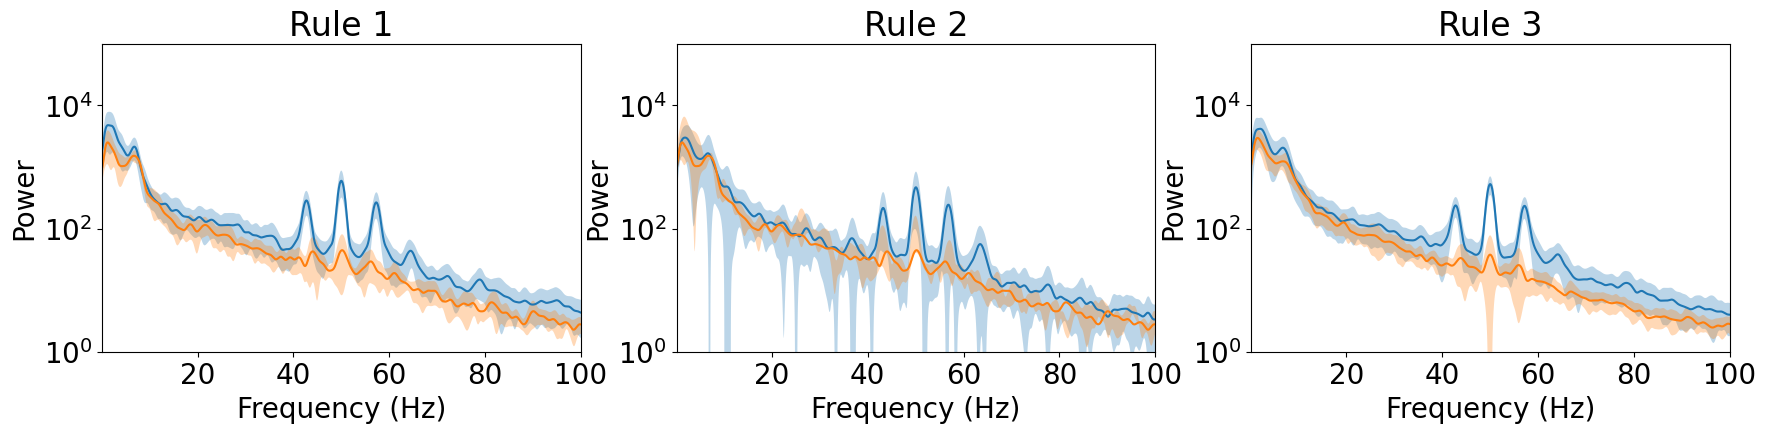

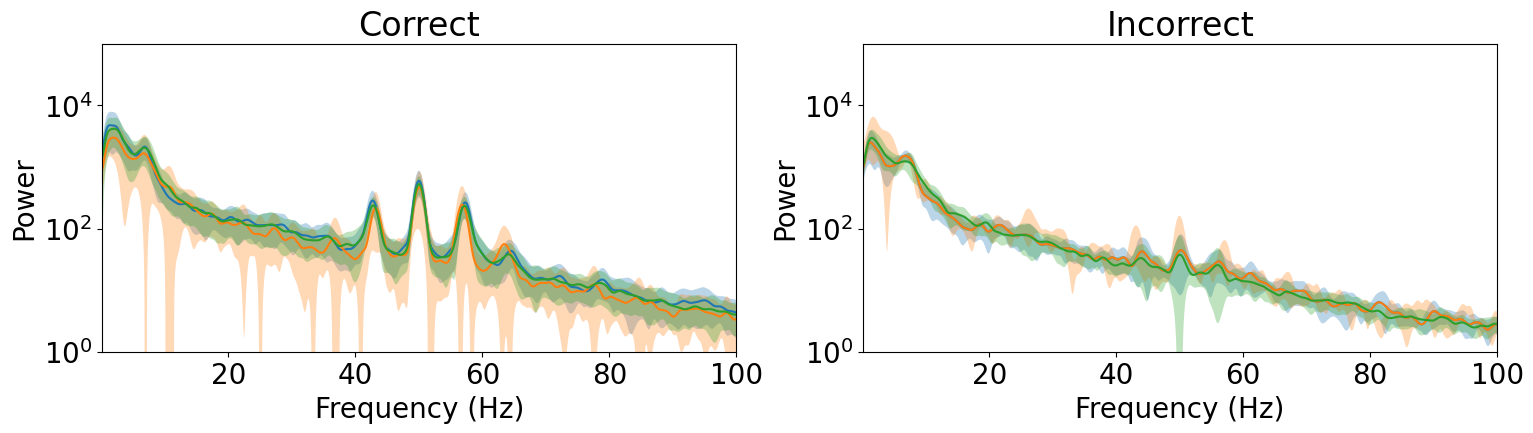

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(21, 4))

axes[0].semilogy(F_r1_c, PS_r1_c, label='Correct')
axes[0].fill_between(F_r1_c, PS_r1_c - PS_r1_c_std, PS_r1_c + PS_r1_c_std, alpha=0.3)
axes[0].semilogy(F_r1_i, PS_r1_i, label='Incorrect')
axes[0].fill_between(F_r1_i, PS_r1_i - PS_r1_i_std, PS_r1_i + PS_r1_i_std, alpha=0.3)
axes[0].set_xlim([0.1, 100])
axes[0].set_ylim([1, 100000])
axes[0].set_title("Rule 1")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Power")

axes[1].semilogy(F_r2_c, PS_r2_c, label='Correct')
axes[1].fill_between(F_r2_c, PS_r2_c - PS_r2_c_std, PS_r2_c + PS_r2_c_std, alpha=0.3)
axes[1].semilogy(F_r1_i, PS_r1_i, label='Incorrect')
axes[1].fill_between(F_r2_i, PS_r2_i - PS_r2_i_std, PS_r2_i + PS_r2_i_std, alpha=0.3)
axes[1].set_xlim([0.1, 100])
axes[1].set_ylim([1, 100000])
axes[1].set_title("Rule 2")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Power")

axes[2].semilogy(F_r3_c, PS_r3_c, label='Correct')
axes[2].fill_between(F_r3_c, PS_r3_c - PS_r3_c_std, PS_r3_c + PS_r3_c_std, alpha=0.3)
axes[2].semilogy(F_r3_i, PS_r3_i, label='Incorrect')
axes[2].fill_between(F_r3_i, PS_r3_i - PS_r3_i_std, PS_r3_i + PS_r3_i_std, alpha=0.3)
axes[2].set_xlim([0.1, 100])
axes[2].set_ylim([1, 100000])
axes[2].set_title("Rule 3")
axes[2].set_xlabel("Frequency (Hz)")
axes[2].set_ylabel("Power")
plt.show()


fig, axes = plt.subplots(1, 2, figsize=(18, 4))

axes[0].semilogy(F_r1_c, PS_r1_c, label='Rule 1')
axes[0].fill_between(F_r1_c, PS_r1_c - PS_r1_c_std, PS_r1_c + PS_r1_c_std, alpha=0.3)
axes[0].semilogy(F_r2_c, PS_r2_c, label='Rule 2')
axes[0].fill_between(F_r2_c, PS_r2_c - PS_r2_c_std, PS_r2_c + PS_r2_c_std, alpha=0.3)
axes[0].semilogy(F_r3_c, PS_r3_c, label='Rule 3')
axes[0].fill_between(F_r3_c, PS_r3_c - PS_r3_c_std, PS_r3_c + PS_r3_c_std, alpha=0.3)
axes[0].set_xlim([0.1, 100])
axes[0].set_ylim([1, 100000])
axes[0].set_title("Correct")
axes[0].set_xlabel("Frequency (Hz)")
axes[0].set_ylabel("Power")

axes[1].semilogy(F_r1_i, PS_r1_i, label='Rule 1')
axes[1].fill_between(F_r1_i, PS_r1_i - PS_r1_i_std, PS_r1_i + PS_r1_i_std, alpha=0.3)
axes[1].semilogy(F_r1_i, PS_r1_i, label='Rule 2')
axes[1].fill_between(F_r2_i, PS_r2_i - PS_r2_i_std, PS_r2_i + PS_r2_i_std, alpha=0.3)
axes[1].semilogy(F_r3_i, PS_r3_i, label='Rule 3')
axes[1].fill_between(F_r3_i, PS_r3_i - PS_r3_i_std, PS_r3_i + PS_r3_i_std, alpha=0.3)
axes[1].set_xlim([0.1, 100])
axes[1].set_ylim([1, 100000])
axes[1].set_title("Incorrect")
axes[1].set_xlabel("Frequency (Hz)")
axes[1].set_ylabel("Power")
plt.show()


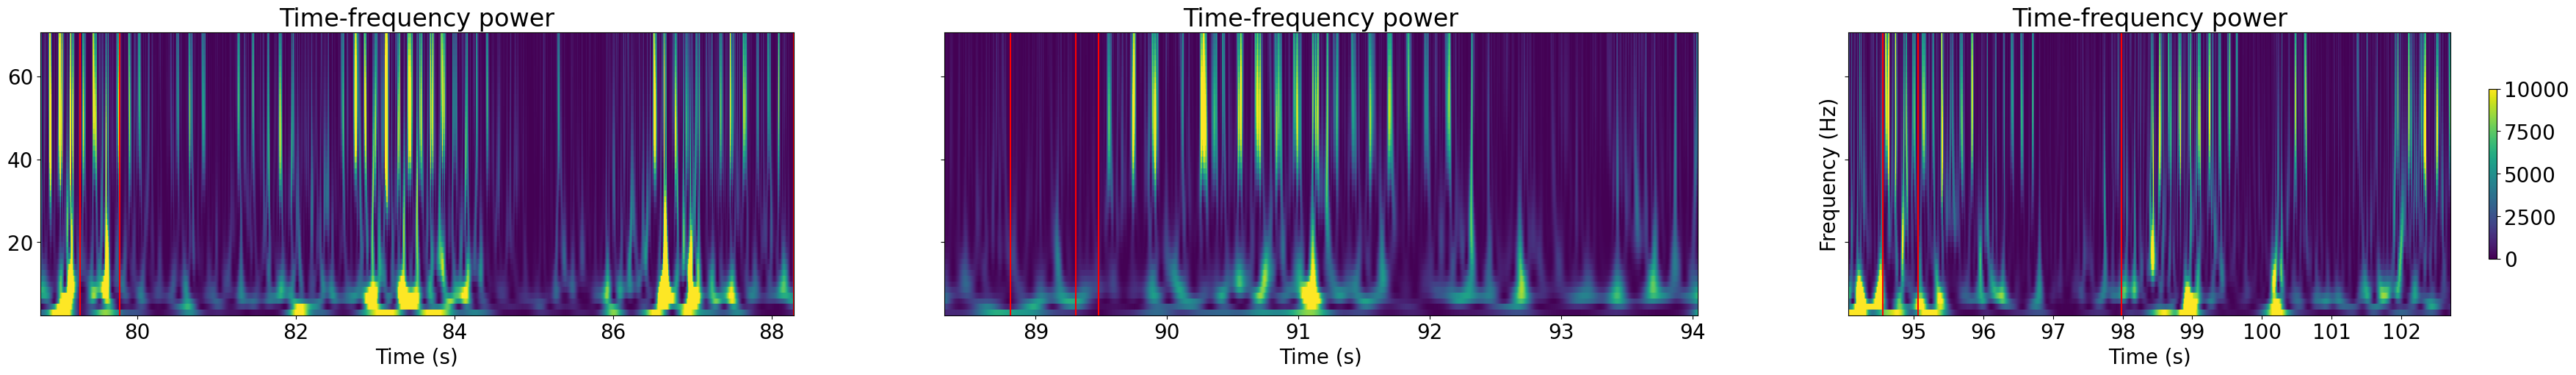

In [22]:
## Now let's apply morlet
# wavelet parameters
nfrex = 50 # 50 frequencies
frex  = np.linspace(3,70,nfrex) # 50 frequencies that are generated linearly between 8 and 70 Hz
fwhm  = 1/frex # full-width at half-maximum in seconds

# time vector for wavelets
wavetime = np.arange(-2,2,1/srate)
N = LFP.shape[0]
timevec = np.arange(0,N)/srate

# initialize matrices for wavelets
wavelets = np.zeros( (nfrex,len(wavetime)) ,dtype=complex)

# create complex Morlet wavelet family
for wi in range(0,nfrex):    
    gaussian = np.exp( -(4*np.log(2)*wavetime**2) / fwhm[wi]**2 )   # Gaussian  
    wavelets[wi,:] = np.exp(1j*2*np.pi*frex[wi]*wavetime) * gaussian # complex Morlet wavelet

# 1 Run convolution using spectral multiplication

#use the fileter data as data
data = LFP # low passes and notched data 

# convolution parameters
nconv = len(timevec) + len(wavetime) - 1 # M+N-1
halfk = int( np.floor(len(wavetime)/2) )

# Fourier spectrum of the signal
dataX = scipy.fftpack.fft(data,nconv) # here we can the fft of the data only once

# initialize time-frequency matrix. The whole trial
tf = np.zeros( (nfrex,len(timevec)) )

# convolution per frequency. We alternatively use the python conv function
for fi in range(0,nfrex):      
    waveX = scipy.fftpack.fft(wavelets[fi,:],nconv)# FFT of the wavelet    
    waveX = waveX / np.abs(np.max(waveX)) # amplitude-normalize the wavelet in the frequency domain    
    convres = scipy.fftpack.ifft( waveX*dataX ) # convolution # inverse of the ifft    
    convres = convres[halfk-1:-halfk]  # trim the "wings"  # result is also complex    
    tf[fi,:] = np.abs(convres)**2 # # extract power from complex signal, we get the magnitude(np.abs)

# Intial and Final temporal points
trials = 3
fig,ax = plt.subplots(1, 3, figsize = (45,5), sharey = True)
i=9
for a in ax:
    i+=1
    Ti = session_ttl["TTL_start"][i]
    Tf = session_ttl["TTL_end"][i]
    Ts = session_ttl["TTL_stim_pres"][i]
    Tcc = session_ttl["TTL_closed_loop"][i]
    To = int(session_ttl["Outcome"][i])
    pcm = a.pcolormesh(timevec[Ti:Tf],frex,tf[:,Ti:Tf],vmin=0,vmax=1e4)
    a.axvline(timevec[Ts],c='r')
    a.axvline(timevec[Tcc],c='r')
    a.axvline(timevec[To],c='r')
    a.set_xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
    a.set_title('Time-frequency power')
fig.colorbar(pcm, shrink=0.6)

Range of trials:  58 - 79


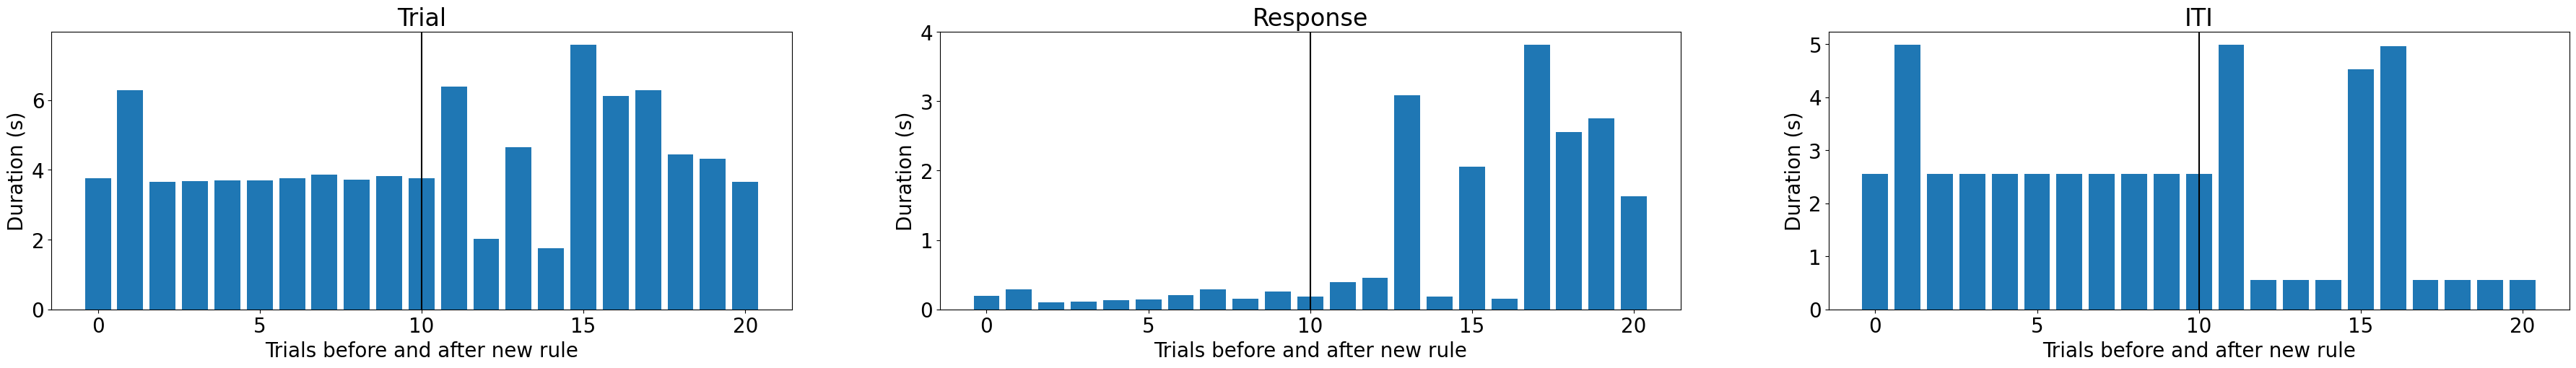

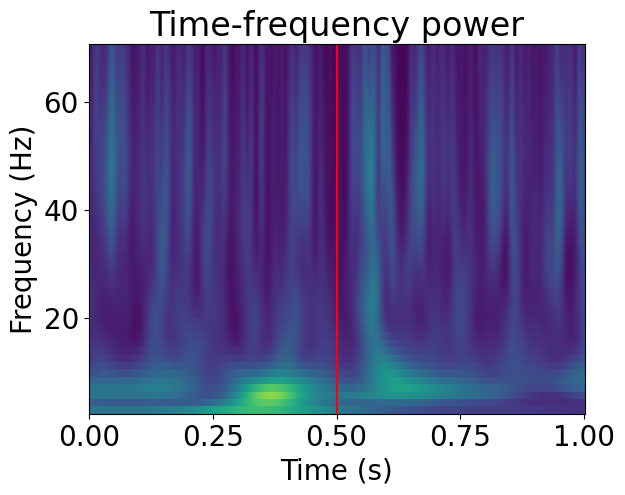

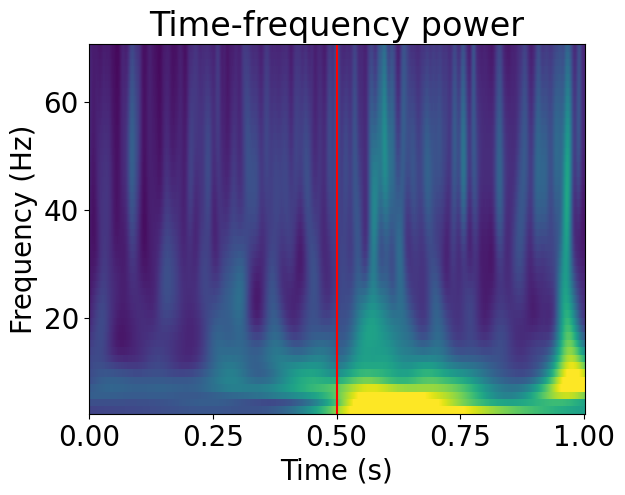

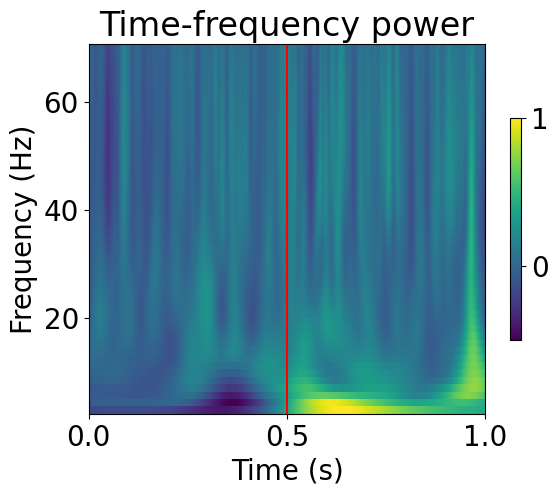

In [23]:
# Selection of trials before and after the rule

new_rule_trial = session_ttl[session_ttl["Rule"]==1].index[0]
trial_ini = new_rule_trial-10
trial_end = new_rule_trial+11
print("Range of trials: ",trial_ini,'-',trial_end)
# Distirbution times
trial_duration = [(session_ttl["TTL_end"][i]-session_ttl["TTL_start"][i])/2500 for i in range(trial_ini,trial_end)]
response_duration =[(session_ttl["Outcome"][i]-session_ttl["TTL_closed_loop"][i])/2500 for i in range(trial_ini,trial_end)] 
iti_duration = [(session_ttl["TTL_end"][i]-session_ttl["Outcome"][i])/2500 for i in range(trial_ini,trial_end)]

fig,ax = plt.subplots(1, 3, figsize = (45,5), sharex=True)
# Full trial
ax[0].bar(range(len(trial_duration)),trial_duration)
ax[0].axvline(10,c='k')
ax[0].set_ylabel("Duration (s)")
ax[0].set_xlabel("Trials before and after new rule")
ax[0].set_title("Trial")
# Response
ax[1].bar(range(len(trial_duration)),response_duration)
ax[1].axvline(10,c='k')
ax[1].set_ylabel("Duration (s)")
ax[1].set_xlabel("Trials before and after new rule")
ax[1].set_title("Response")
# ITI
ax[2].bar(range(len(trial_duration)),iti_duration)
ax[2].axvline(10,c='k')
ax[2].set_ylabel("Duration (s)")
ax[2].set_xlabel("Trials before and after new rule")
ax[2].set_title("ITI")

# Frozen time
sampling_length = session_ttl["TTL_closed_loop"][trial_ini]-session_ttl["TTL_start"][trial_ini]
section_length = trial_end-trial_ini
section_froz = np.full((nfrex,sampling_length,section_length),np.nan)
k=0
for i in range(trial_ini,trial_end):
    Tcc = session_ttl["TTL_closed_loop"][i]
    Ti = Tcc-sampling_length
    section_froz[:,:,k]=tf[:,Ti:Tcc]
    k+=1

bef = section_froz[:,:,0:11].mean(2)
aft = section_froz[:,:,11::].mean(2)
plt.figure()
pcm = plt.pcolormesh(np.linspace(0,sampling_length/2500,sampling_length),frex,bef,vmin=0,vmax=8e3)
plt.axvline(0.5,c="r")
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power')
plt.figure()
pcm = plt.pcolormesh(np.linspace(0,sampling_length/2500,sampling_length),frex,aft,vmin=0,vmax=8e3)
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power')
plt.axvline(0.5,c="r")


plt.figure()
pcm = plt.pcolormesh(np.linspace(0,sampling_length/2500,sampling_length),frex,(aft-bef)/np.abs(aft-bef).max())
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power')
plt.axvline(0.5,c="r")
plt.colorbar(pcm, shrink=0.6)


Range of trials:  103 - 124


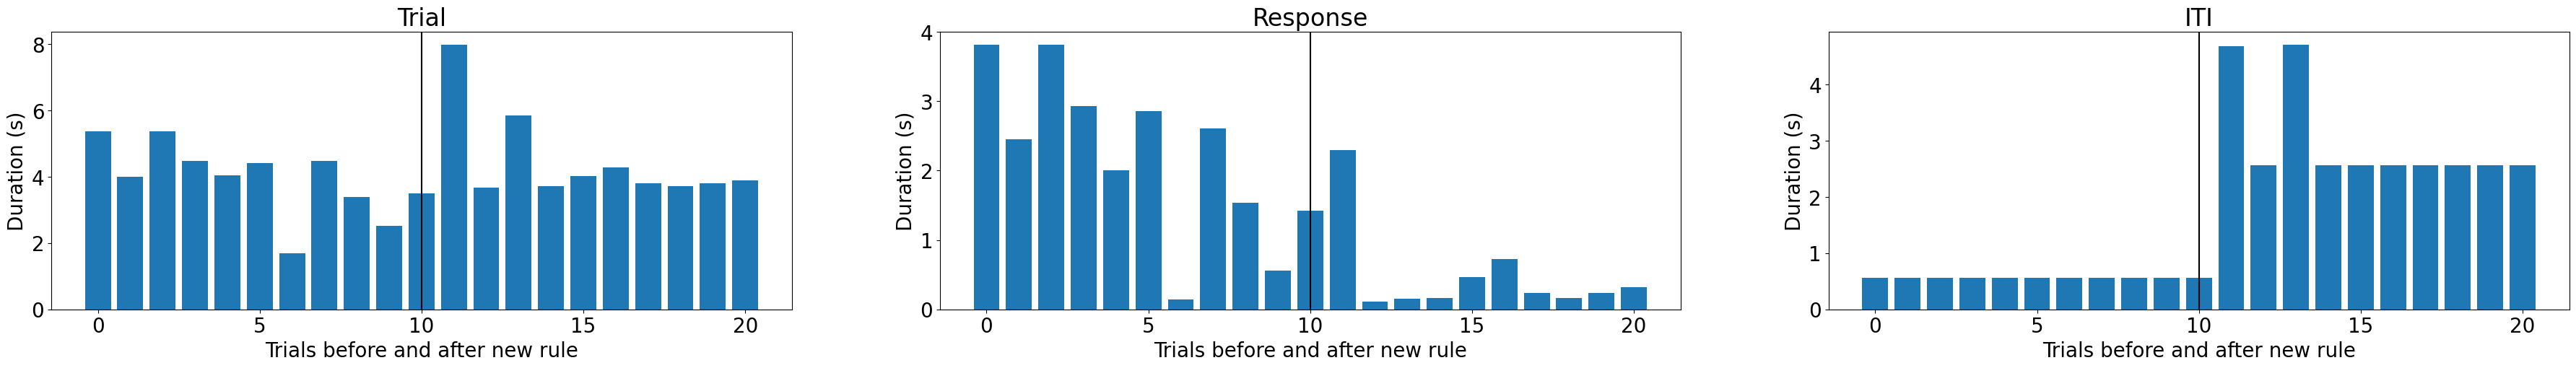

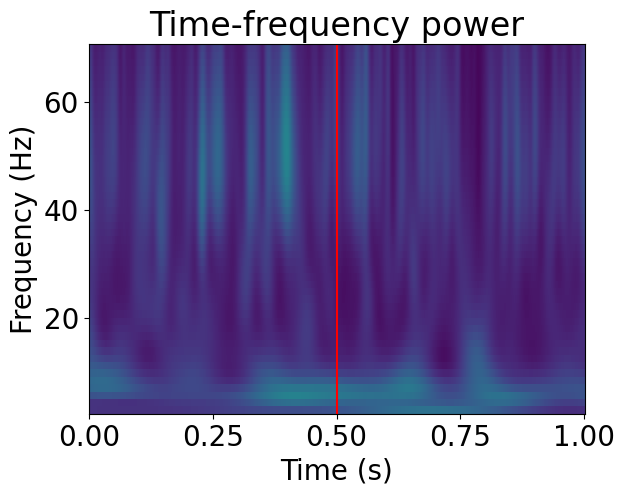

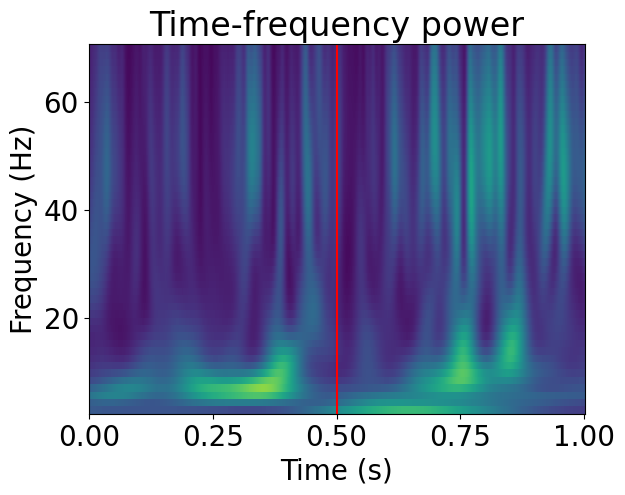

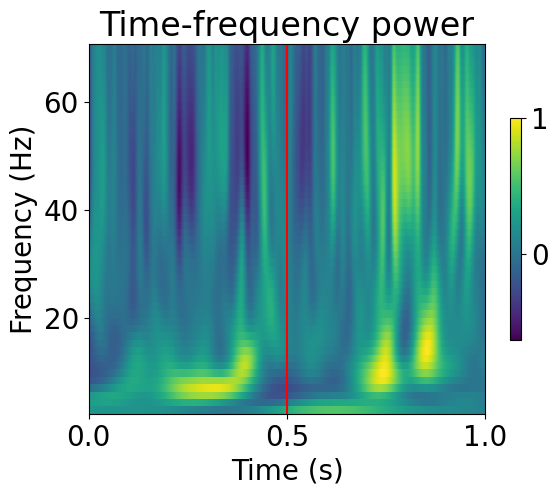

In [24]:
# Selection of trials before and after the rule

new_rule_trial = session_ttl[session_ttl["Rule"]==2].index[0]
trial_ini = new_rule_trial-10
trial_end = new_rule_trial+11
print("Range of trials: ",trial_ini,'-',trial_end)

# Distirbution times
trial_duration = [(session_ttl["TTL_end"][i]-session_ttl["TTL_start"][i])/2500 for i in range(trial_ini,trial_end)]
response_duration =[(session_ttl["Outcome"][i]-session_ttl["TTL_closed_loop"][i])/2500 for i in range(trial_ini,trial_end)] 
iti_duration = [(session_ttl["TTL_end"][i]-session_ttl["Outcome"][i])/2500 for i in range(trial_ini,trial_end)]

fig,ax = plt.subplots(1, 3, figsize = (45,5), sharex=True)
# Full trial
ax[0].bar(range(len(trial_duration)),trial_duration)
ax[0].axvline(10,c='k')
ax[0].set_ylabel("Duration (s)")
ax[0].set_xlabel("Trials before and after new rule")
ax[0].set_title("Trial")
# Response
ax[1].bar(range(len(trial_duration)),response_duration)
ax[1].axvline(10,c='k')
ax[1].set_ylabel("Duration (s)")
ax[1].set_xlabel("Trials before and after new rule")
ax[1].set_title("Response")
# ITI
ax[2].bar(range(len(trial_duration)),iti_duration)
ax[2].axvline(10,c='k')
ax[2].set_ylabel("Duration (s)")
ax[2].set_xlabel("Trials before and after new rule")
ax[2].set_title("ITI")

# Frozen time
sampling_length = session_ttl["TTL_closed_loop"][trial_ini]-session_ttl["TTL_start"][trial_ini]
section_length = trial_end-trial_ini
section_froz = np.full((nfrex,sampling_length,section_length),np.nan)
k=0
for i in range(trial_ini,trial_end):
    Tcc = session_ttl["TTL_closed_loop"][i]
    Ti = Tcc-sampling_length
    section_froz[:,:,k]=tf[:,Ti:Tcc]
    k+=1

bef = section_froz[:,:,0:11].mean(2)
aft = section_froz[:,:,11::].mean(2)
plt.figure()
pcm = plt.pcolormesh(np.linspace(0,sampling_length/2500,sampling_length),frex,bef,vmin=0,vmax=8e3)
plt.axvline(0.5,c="r")
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power')
plt.figure()
pcm = plt.pcolormesh(np.linspace(0,sampling_length/2500,sampling_length),frex,aft,vmin=0,vmax=8e3)
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power')
plt.axvline(0.5,c="r")

plt.figure()
pcm = plt.pcolormesh(np.linspace(0,sampling_length/2500,sampling_length),frex,(aft-bef)/np.abs(aft-bef).max())
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power')
plt.axvline(0.5,c="r")
plt.colorbar(pcm, shrink=0.6)


Range of trials:  203 - 224


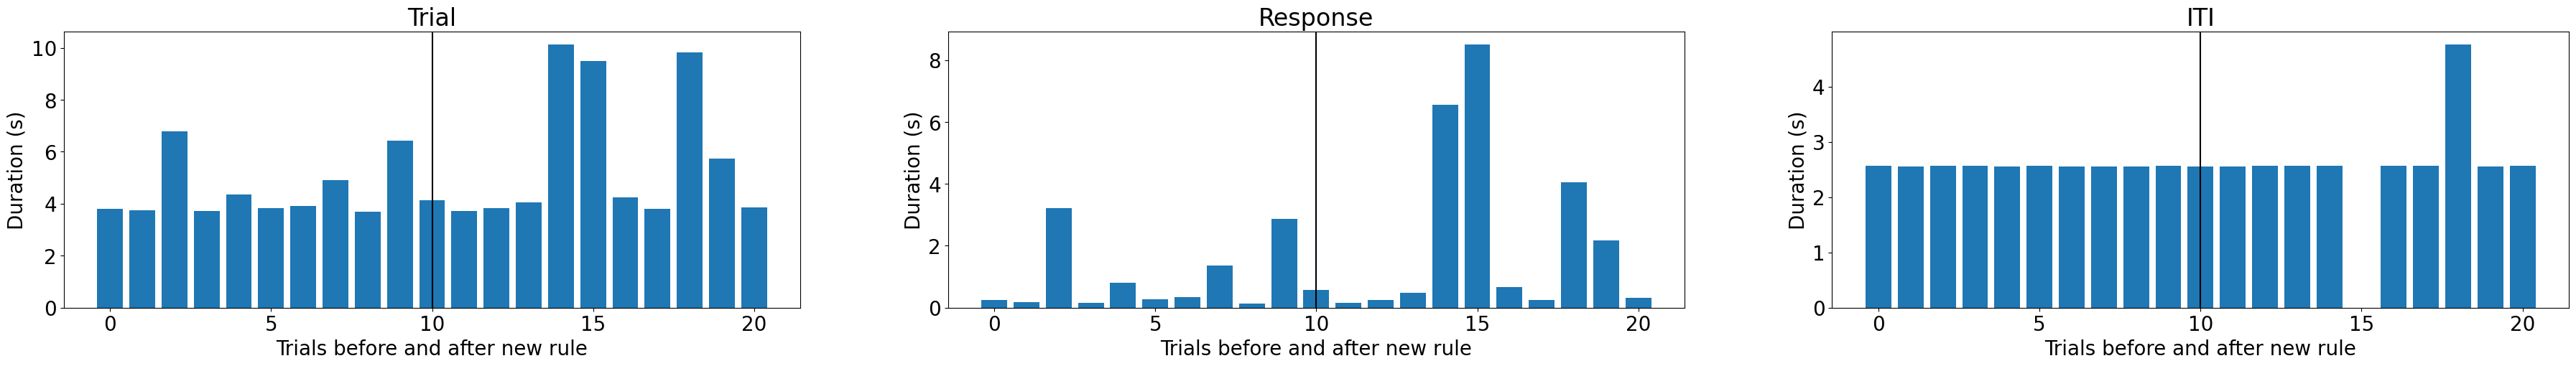

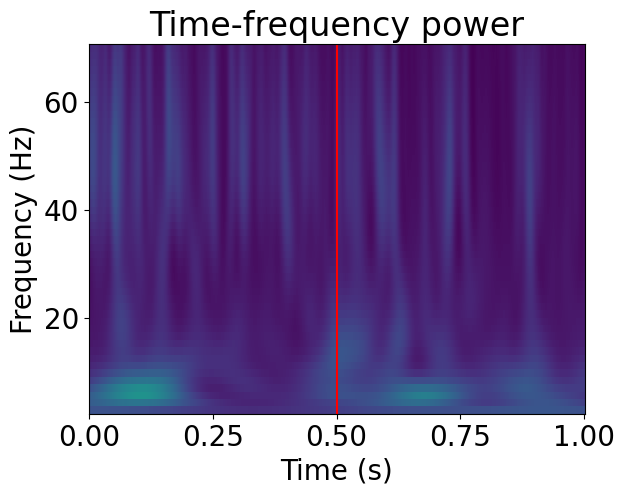

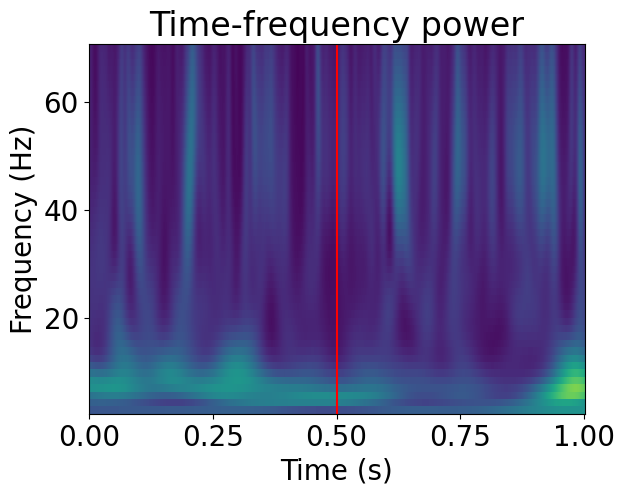

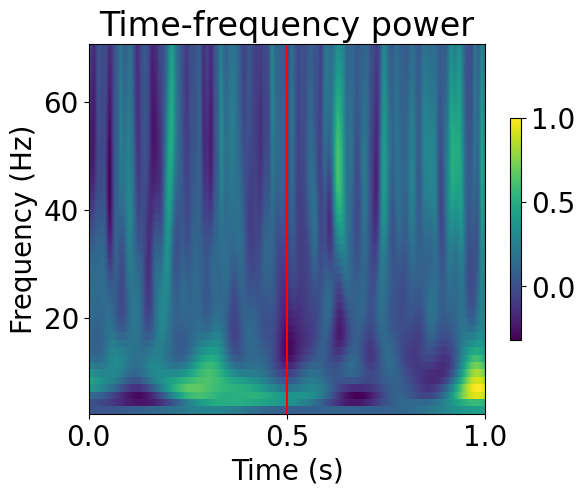

In [26]:

new_rule_trial = session_ttl[session_ttl["Rule"]==2].index[0]+100
trial_ini = new_rule_trial-10
trial_end = new_rule_trial+11
print("Range of trials: ",trial_ini,'-',trial_end)

# Distirbution times
trial_duration = [(session_ttl["TTL_end"][i]-session_ttl["TTL_start"][i])/2500 for i in range(trial_ini,trial_end)]
response_duration =[(session_ttl["Outcome"][i]-session_ttl["TTL_closed_loop"][i])/2500 for i in range(trial_ini,trial_end)] 
iti_duration = [(session_ttl["TTL_end"][i]-session_ttl["Outcome"][i])/2500 for i in range(trial_ini,trial_end)]

fig,ax = plt.subplots(1, 3, figsize = (45,5), sharex=True)
# Full trial
ax[0].bar(range(len(trial_duration)),trial_duration)
ax[0].axvline(10,c='k')
ax[0].set_ylabel("Duration (s)")
ax[0].set_xlabel("Trials before and after new rule")
ax[0].set_title("Trial")
# Response
ax[1].bar(range(len(trial_duration)),response_duration)
ax[1].axvline(10,c='k')
ax[1].set_ylabel("Duration (s)")
ax[1].set_xlabel("Trials before and after new rule")
ax[1].set_title("Response")
# ITI
ax[2].bar(range(len(trial_duration)),iti_duration)
ax[2].axvline(10,c='k')
ax[2].set_ylabel("Duration (s)")
ax[2].set_xlabel("Trials before and after new rule")
ax[2].set_title("ITI")

# Frozen time
sampling_length = session_ttl["TTL_closed_loop"][trial_ini]-session_ttl["TTL_start"][trial_ini]
section_length = trial_end-trial_ini
section_froz = np.full((nfrex,sampling_length,section_length),np.nan)
k=0
for i in range(trial_ini,trial_end):
    Tcc = session_ttl["TTL_closed_loop"][i]
    Ti = Tcc-sampling_length
    section_froz[:,:,k]=tf[:,Ti:Tcc]
    k+=1

bef = section_froz[:,:,0:11].mean(2)
aft = section_froz[:,:,11::].mean(2)
plt.figure()
pcm = plt.pcolormesh(np.linspace(0,sampling_length/2500,sampling_length),frex,bef,vmin=0,vmax=8e3)
plt.axvline(0.5,c="r")
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power')
plt.figure()
pcm = plt.pcolormesh(np.linspace(0,sampling_length/2500,sampling_length),frex,aft,vmin=0,vmax=8e3)
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power')
plt.axvline(0.5,c="r")

plt.figure()
pcm = plt.pcolormesh(np.linspace(0,sampling_length/2500,sampling_length),frex,(aft-bef)/np.abs(aft-bef).max())
plt.xlabel('Time (s)'), plt.ylabel('Frequency (Hz)')
plt.title('Time-frequency power')
plt.axvline(0.5,c="r")
plt.colorbar(pcm, shrink=0.6)